In [1]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, Conv2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using TensorFlow backend.
/Users/mylesfoley/opt/anaconda3/envs/tensorflow_cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mylesfoley/opt/anaconda3/envs/tensorflow_cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mylesfoley/opt/anaconda3/envs/tensorflow_cpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

In [3]:
# Load the labels of the dataset 
path = str(sys.path[0])[:-2]
smile_labels = pd.read_csv(path + '/Datasets/dataset_AMLS_19-20/celeba/labels.csv', delimiter='\t')
smile_labels = smile_labels.iloc[:,1:4]
smile_dict = {1: 1, -1: 0}
smile_labels["smiling"].replace(smile_dict, inplace=True)
smile_labels = smile_labels.drop('gender', axis=1)
smile_labels.head()

,img_name,smiling
0,0.jpg,1
1,1.jpg,1
2,2.jpg,0
3,3.jpg,0
4,4.jpg,0


In [4]:
# Split into male and female data
smile_data = smile_labels[(smile_labels['smiling'] == 1)]
no_smile_data = smile_labels[smile_labels['smiling'] == 0]

In [5]:
# Splitting male and female data into train and test
train_smile_data, test_smile_data = train_test_split(smile_data)
train_no_smile_data, test_no_smile_data = train_test_split(no_smile_data)
train_no_smile_data.head()

,img_name,smiling
3689,3689.jpg,0
3232,3232.jpg,0
3376,3376.jpg,0
3942,3942.jpg,0
1921,1921.jpg,0


In [6]:
# Create final test data set out of male and female data
test_indices = test_no_smile_data.index.tolist() + test_smile_data.index.tolist()
test_data = smile_labels.iloc[test_indices,:]
test_data.head()

,img_name,smiling
4540,4540.jpg,0
90,90.jpg,0
1135,1135.jpg,0
498,498.jpg,0
2206,2206.jpg,0


In [7]:
# Filter the training data from the labels 
train_data = pd.concat([smile_labels, test_data, test_data]).drop_duplicates(keep=False)
train_data.head()

,img_name,smiling
0,0.jpg,1
1,1.jpg,1
2,2.jpg,0
3,3.jpg,0
5,5.jpg,0


In [8]:
# Read the image names 
img_path = path + 'Datasets/dataset_AMLS_19-20/celeba/img/' # path of your image folder
train_image_name = [img_path + each for each in train_data['img_name'].values.tolist()]
test_image_name = [img_path + each for each in test_data['img_name'].values.tolist()]

In [9]:
# Downsample the images for training

ROWS = 64
COLS = 64
CHANNELS = 3

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) 
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%500 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_image_name)
test = prep_data(test_image_name)




Processed 0 of 3750
Processed 500 of 3750
Processed 1000 of 3750
Processed 1500 of 3750
Processed 2000 of 3750
Processed 2500 of 3750
Processed 3000 of 3750
Processed 3500 of 3750
Processed 0 of 1250
Processed 500 of 1250
Processed 1000 of 1250


In [11]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def smile_categoriser():
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(3, ROWS, COLS)))
    model.add(MaxPooling2D(pool_size=(2,2), data_format="channels_first"))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), data_format="channels_first"))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), data_format="channels_first"))
    model.add(BatchNormalization())
    
    model.add(Conv2D(96, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), data_format="channels_first"))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), data_format="channels_first"))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation = 'softmax'))
    

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = smile_categoriser()

In [12]:
def get_labels(data):
    labels=[]
    for label in data:
        if label == 0: labels.append(np.array([1, 0]))
        elif label == 1 : labels.append(np.array([0, 1]))
    return np.array(labels)

    

In [13]:
nb_epoch = 100
batch_size = 15
y_train = get_labels(train_data.iloc[:,1].values.tolist())


early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)  

In [14]:
print(y_train.shape)

(3750, 2)


In [15]:
history = model.fit(train, y_train, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Epoch 00017: early stopping


In [16]:
predictions = model.predict(test, verbose=0)
predictions

array([[0.9856163 , 0.01438375],
       [0.99891365, 0.0010864 ],
       [0.9760849 , 0.02391508],
       ...,
       [0.01663869, 0.9833613 ],
       [0.47815168, 0.5218484 ],
       [0.0632334 , 0.93676656]], dtype=float32)

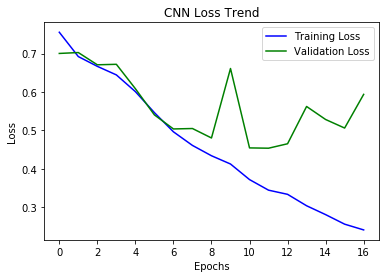

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,len(history.history['loss']))[0::2])
plt.legend()
plt.show()

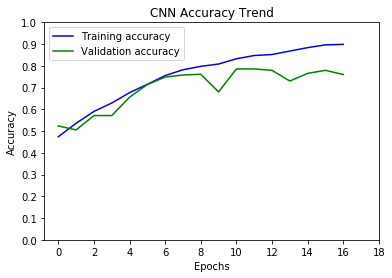

In [18]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Accuracy Trend')
plt.plot(accuracy, 'blue', label='Training accuracy')
plt.plot(val_accuracy, 'green', label='Validation accuracy')
plt.xticks(range(0,len(history.history['loss'])+2)[0::2])
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.legend()
plt.show()

In [19]:
test_val = get_labels(test_data.iloc[:,1].values.tolist())
model.evaluate(test, test_val, verbose=1)

1250/1250 [==============================] - 0s 265us/step


[0.5024739001750946, 0.7848]

In [20]:
predict_val=[]
for array in predictions:
    predict_val.append(np.argmax(array))

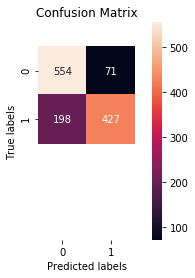

In [21]:
cm =confusion_matrix(test_data.iloc[:,1].values.tolist(), predict_val)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="d", square=True); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_ylim(5-1, -0.5)
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4']); 
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4']);